# Production planning

In this example  product A represent 'scooter', and product B represents 'Bike'.

--- Simulating one trajectory for each policy ---
Running policy: Greedy (Lowest Inv)
Running policy: Setup-Aware
Running policy: Always Produce A
Running policy: Always Produce B
Running policy: Never Switch
Running policy: Random Action


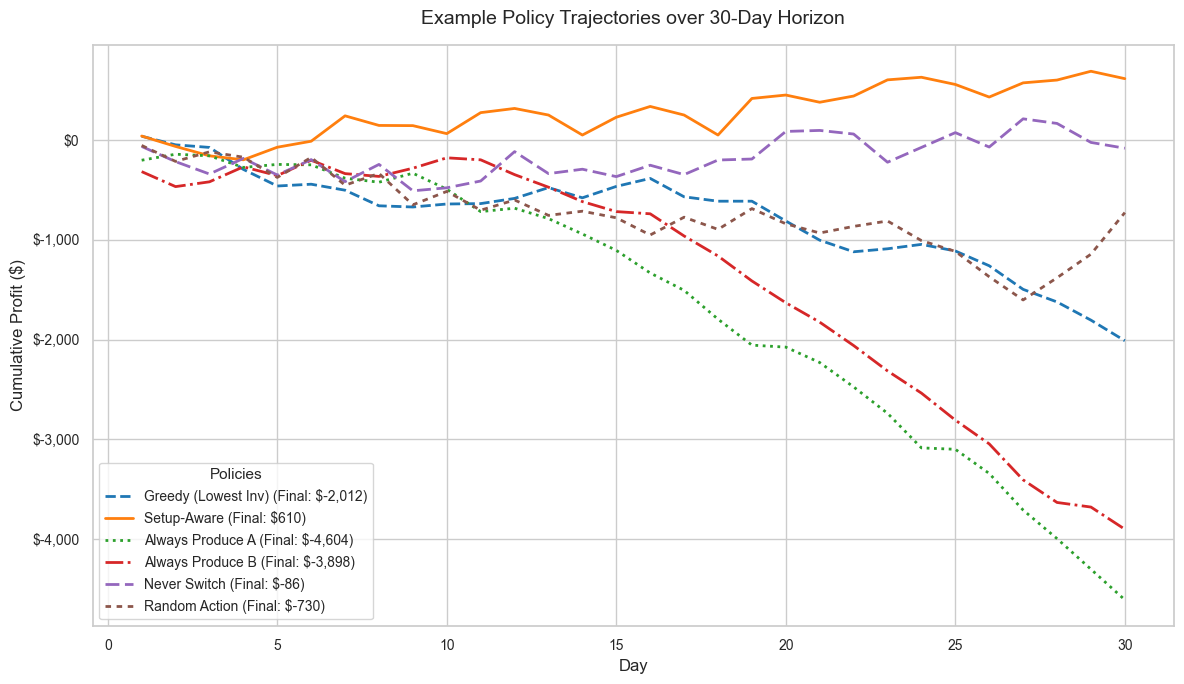


--- Running Simulation (1000 episodes) ---
  Simulating episode 100/1000...
  Simulating episode 200/1000...
  Simulating episode 300/1000...
  Simulating episode 400/1000...
  Simulating episode 500/1000...
  Simulating episode 600/1000...
  Simulating episode 700/1000...
  Simulating episode 800/1000...
  Simulating episode 900/1000...
  Simulating episode 1000/1000...
Simulation complete.

--- Preparing data for visualization ---
--- Generating Plot of Profit Distributions ---


/var/folders/73/1wstfjwn76s193_38n9l19_h0000gn/T/ipykernel_37329/2123668594.py:254: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.displot(


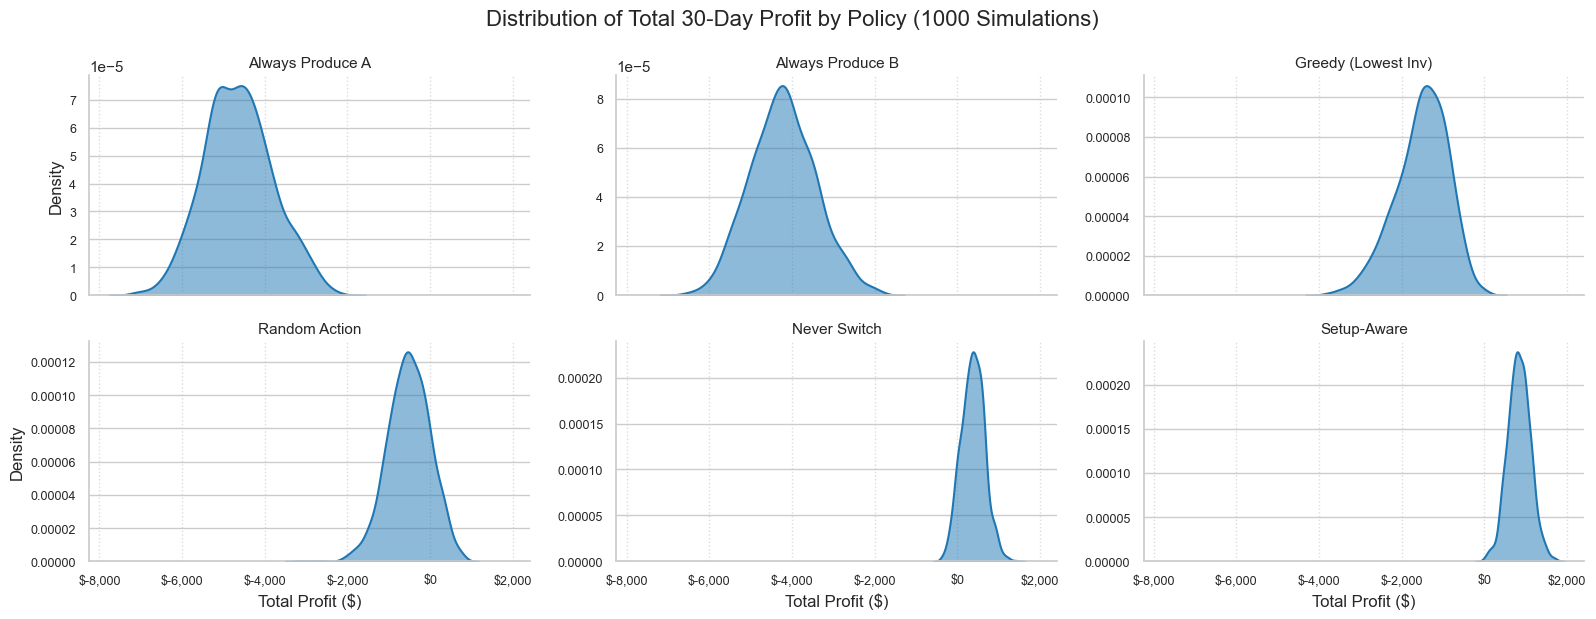


--- Summary Statistics (Total Profit over Horizon) ---
(Based on 1000 simulations, sorted by Mean Profit, Ascending)
----------------------------------------------------------------------
Policy                    | Mean Profit ($) | Std Dev ($)
----------------------------------------------------------------------
Always Produce A          |     -4,639.8 |      831.8
Always Produce B          |     -4,221.4 |      792.9
Greedy (Lowest Inv)       |     -1,522.3 |      640.0
Random Action             |       -520.1 |      519.1
Never Switch              |        374.1 |      279.5
Setup-Aware               |        833.3 |      274.5
----------------------------------------------------------------------


In [4]:
# Required libraries - make sure pandas and seaborn are installed
# pip install numpy matplotlib pandas seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Needed for structuring data for seaborn
import seaborn as sns # Used for styling and plotting
from dataclasses import dataclass
import collections
import warnings

# Suppress specific warnings if necessary (e.g., tight_layout adjustments)
warnings.filterwarnings("ignore", message="Tight layout not applied.*")

# set seed for reproducibility
np.random.seed(1000)

# ------------------ MDP Definition: Factory Production Problem ------------------ #

# --- 1. Parameters ---
@dataclass
class FactoryProblemDefinition:
    """Holds all the fixed parameters of our Factory MDP."""
    lambda_A: float = 4.0       # Mean daily demand for product A (Poisson lambda)
    lambda_B: float = 3.0       # Mean daily demand for product B (Poisson lambda)
    horizon: int = 30          # Planning horizon in days

    prod_capacity_A: int = 8   # Units of A produced if machine is set to A
    prod_capacity_B: int = 6   # Units of B produced if machine is set to B

    price_A: float = 40.0      # Revenue per unit of A ($)
    price_B: float = 50.0      # Revenue per unit of B ($)
    cost_A: float = 20.0       # Production cost per unit of A ($)
    cost_B: float = 25.0       # Production cost per unit of B ($)

    setup_cost: float = 200.0  # Cost incurred when switching production setup ($)
    holding_cost: float = 2.0  # Cost per unit of inventory held overnight ($)
    backorder_cost: float = 10.0 # Cost per unit of unmet demand (backordered) ($)

# --- 2. State Space (S) ---
# A state is defined by: (current_day, inventory_A, inventory_B, machine_setup)
# Example initial state: (0, 0, 0, 0) # Day 0, no inventory, machine set for A

# --- 3. Action Space (A) ---
# Actions available at each state (decision at the start of the day):
ACTIONS = {0: "Produce A", 1: "Produce B", 2: "Idle"}

# --- 4. Transition Function P(s' | s, a) ---
def sample_demand(params: FactoryProblemDefinition):
    """Samples the stochastic demand for one day."""
    demand_A = np.random.poisson(params.lambda_A)
    demand_B = np.random.poisson(params.lambda_B)
    return demand_A, demand_B

def transition(state, action, demand, params: FactoryProblemDefinition):
    """
    Calculates the next state s' given current state s, action a,
    and the realized demand for the day. Also returns intermediate values
    needed for reward calculation.
    """
    day, inv_A, inv_B, current_setup = state
    demand_A, demand_B = demand

    produced_A = params.prod_capacity_A if action == 0 else 0
    produced_B = params.prod_capacity_B if action == 1 else 0

    inv_A += produced_A
    inv_B += produced_B

    satisfied_A = min(inv_A, demand_A)
    satisfied_B = min(inv_B, demand_B)

    inv_A -= satisfied_A
    inv_B -= satisfied_B

    backorder_A = demand_A - satisfied_A # Unmet demand for A
    backorder_B = demand_B - satisfied_B # Unmet demand for B

    next_setup = action if action in (0, 1) else current_setup
    next_day = day + 1
    next_state = (next_day, inv_A, inv_B, next_setup)

    return next_state, produced_A, produced_B, backorder_A, backorder_B

# --- 5. Reward Function R(s, a, s') ---
def reward_function(state, action, demand, params: FactoryProblemDefinition,
                    produced_A, produced_B, backorder_A, backorder_B, next_state):
    """
    Calculates the immediate reward for the transition.
    """
    _day, _inv_A, _inv_B, current_setup = state
    _next_day, next_inv_A, next_inv_B, _next_setup = next_state
    demand_A, demand_B = demand

    revenue = (demand_A - backorder_A) * params.price_A + \
              (demand_B - backorder_B) * params.price_B
    production_cost = produced_A * params.cost_A + produced_B * params.cost_B
    setup_penalty = params.setup_cost if (action in (0, 1) and action != current_setup) else 0
    holding_penalty = params.holding_cost * (next_inv_A + next_inv_B)
    backorder_penalty = params.backorder_cost * (backorder_A + backorder_B)

    total_reward = revenue - production_cost - setup_penalty - holding_penalty - backorder_penalty

    return total_reward

# ------------------ Policy Definitions (Maps State -> Action) ------------------ #
def greedy_policy(state, params: FactoryProblemDefinition):
    _day, inv_A, inv_B, _setup = state
    if inv_A < inv_B: return 0
    elif inv_B < inv_A: return 1
    else: return 0 # Default to A if tied

def setup_aware_policy(state, params: FactoryProblemDefinition):
    _day, inv_A, inv_B, current_setup = state
    safety_stock = 5
    critical_stock = 2
    if current_setup == 0 and inv_A < safety_stock: return 0
    if current_setup == 1 and inv_B < safety_stock: return 1
    if current_setup == 1 and inv_A < critical_stock: return 0
    if current_setup == 0 and inv_B < critical_stock: return 1
    return 2

def always_produce_A_policy(state, params: FactoryProblemDefinition): return 0
def always_produce_B_policy(state, params: FactoryProblemDefinition): return 1

def never_switch_policy(state, params: FactoryProblemDefinition):
    _day, inv_A, inv_B, current_setup = state
    target_stock = 15
    if current_setup == 0: return 0 if inv_A < target_stock else 2
    else: return 1 if inv_B < target_stock else 2

def random_policy(state, params: FactoryProblemDefinition):
    return np.random.choice([0, 1, 2])

# --- Dictionary of policies for easy access ---
POLICIES = {
    "Greedy (Lowest Inv)": greedy_policy,
    "Setup-Aware": setup_aware_policy,
    "Always Produce A": always_produce_A_policy,
    "Always Produce B": always_produce_B_policy,
    "Never Switch": never_switch_policy,
    "Random Action": random_policy
}

# ------------------ Simulation Logic ------------------ #
def simulate_trajectory(initial_state, policy_fn, params: FactoryProblemDefinition):
    """Runs one full simulation (episode) using a given policy."""
    state = initial_state
    daily_rewards = []
    cumulative_rewards = []
    total_profit = 0.0

    while state[0] < params.horizon:
        action = policy_fn(state, params)
        demand = sample_demand(params)
        next_state, prod_A, prod_B, back_A, back_B = transition(state, action, demand, params)
        reward = reward_function(state, action, demand, params, prod_A, prod_B, back_A, back_B, next_state)
        daily_rewards.append(reward)
        total_profit += reward
        cumulative_rewards.append(total_profit)
        state = next_state

    return daily_rewards, cumulative_rewards, total_profit

# ------------------ Running Simulations and Visualization ------------------ #

# --- Setup ---
factory_params = FactoryProblemDefinition()
initial_state = (0, 0, 0, 0) # Start at day 0, no inventory, machine set for A
num_episodes = 1000           # Number of simulations for Monte Carlo analysis
currency_symbol = "$"        # Define currency symbol

# Use a seaborn style for better aesthetics. 'whitegrid' is a clean choice.
# Use 'tab10' palette for good color distinction in line plots.
sns.set_theme(style="whitegrid", palette="tab10")

# --- 1. Single Trajectory Illustration ---
print("--- Simulating one trajectory for each policy ---")
plt.figure(figsize=(12, 7)) # Slightly larger figure
ax1 = plt.gca() # Get current axes

# Use seaborn's color palette explicitly if needed, otherwise theme handles it
# colors = sns.color_palette("tab10", len(POLICIES))

policy_linestyles = {
    'Greedy (Lowest Inv)': '--',
    'Setup-Aware': '-',       # Solid line
    'Always Produce A': ':',  # Dotted line
    'Always Produce B': '-.', # Dash-dot line
    'Never Switch': (0, (5, 2)),  # Custom dash
    'Random Action': (0, (2, 2))             # dense dotted for visibility
}

for name, policy in POLICIES.items():
    print(f"Running policy: {name}")
    _, cumulative, final_profit = simulate_trajectory(initial_state, policy, factory_params)
    # Plot with clear label including final profit
    ax1.plot(
        range(1, factory_params.horizon + 1),
        cumulative,
        label=f"{name} (Final: {currency_symbol}{final_profit:,.0f})", # Format currency
        linewidth=2, # Slightly thicker lines
        #shape of line for each policies: if setup_aware_policy, use solid line, otherwise with other shapes for other policies uniquly
        linestyle = policy_linestyles.get(name, '-')  # default to solid

    )

# Plot formatting
ax1.set_xlabel("Day", fontsize=12)
ax1.set_ylabel(f"Cumulative Profit ({currency_symbol})", fontsize=12)
ax1.set_title(f"Example Policy Trajectories over {factory_params.horizon}-Day Horizon", fontsize=14, pad=15)
ax1.tick_params(axis='both', which='major', labelsize=10)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{currency_symbol}{x:,.0f}')) # Format y-axis ticks as currency
ax1.legend(fontsize=10, title="Policies", title_fontsize='11')
# ax1.grid(True, linestyle='--', alpha=0.6) # whitegrid style includes grid
plt.tight_layout()
plt.show()

# --- 2. Comparison (Distribution of Total Profits) ---
print(f"\n--- Running Simulation ({num_episodes} episodes) ---")
results = collections.defaultdict(list)

for i in range(num_episodes):
    if (i + 1) % (num_episodes // 10) == 0: # Progress update every 10%
        print(f"  Simulating episode {i+1}/{num_episodes}...")
    for name, policy in POLICIES.items():
        _, _, total_profit = simulate_trajectory(initial_state, policy, factory_params)
        results[name].append(total_profit)

print("Simulation complete.")

# --- 3. Prepare Data ---
print("\n--- Preparing data for visualization ---")
data_list = []
for policy_name, profit_list in results.items():
    for profit in profit_list:
        data_list.append({"Policy": policy_name, "Total Profit": profit})
results_df = pd.DataFrame(data_list)

# --- 4. Plotting the Distribution of Results using Faceted KDE Plots ---
print("--- Generating Plot of Profit Distributions ---")

# Calculate mean profits to order the plot
mean_profits = results_df.groupby("Policy")["Total Profit"].mean().sort_values()
ordered_policies = mean_profits.index.tolist()

# Determine number of columns for the plot grid (e.g., 3)
num_policies = len(ordered_policies)
num_cols = 3
# num_rows = (num_policies + num_cols - 1) // num_cols # displot handles wrapping

# Create the faceted plot using displot with kind='kde'
# Use a sequential palette like 'viridis' or 'magma' for density
 
g = sns.displot(
    data=results_df,
    x="Total Profit",
    col="Policy",               # Create a column for each policy
    col_wrap=num_cols,          # Wrap columns after 'num_cols'
    col_order=ordered_policies, # Order the columns by mean profit
    kind="kde",                 # Use Kernel Density Estimate plots
    fill=True,                  # Fill the area under the curves
    palette="viridis",          # Palette suitable for density
    linewidth=1.5,
    alpha=0.5,
    facet_kws={'sharey': False, # Each plot has its own y-axis scale (density)
               'sharex': True}, # All plots share the same x-axis (profit)
    height=3,                   # Height of each facet
    aspect=1.8                  # Aspect ratio of each facet (width/height)
)


g.fig.suptitle(f'Distribution of Total {factory_params.horizon}-Day Profit by Policy ({num_episodes} Simulations)',
               fontsize=16, y=1.03) # Add overall title slightly above facets
g.set_axis_labels(f"Total Profit ({currency_symbol})", "Density", fontsize=12)
g.set_titles("{col_name}", size=11) # Set title for each subplot
g.fig.subplots_adjust(top=0.92) # Adjust top to make space for suptitle

# Format x-axis ticks as currency for all subplots
for ax in g.axes.flat:
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{currency_symbol}{x:,.0f}'))
    ax.tick_params(axis='x', labelsize=9)
    ax.tick_params(axis='y', labelsize=9)
    # Add light grid lines to x-axis on each facet
    ax.grid(True, axis='x', linestyle=':', alpha=0.7)


plt.show()


# --- 5. Printing Summary Statistics ---
print("\n--- Summary Statistics (Total Profit over Horizon) ---")
print(f"(Based on {num_episodes} simulations, sorted by Mean Profit, Ascending)")
print("-" * 70)
print(f"{'Policy':<25s} | Mean Profit ({currency_symbol}) | Std Dev ({currency_symbol})")
print("-" * 70)
for policy_name in ordered_policies: # Iterate using the sorted order
    totals = results[policy_name]
    mean_profit = np.mean(totals)
    std_dev = np.std(totals)
    # Format output clearly with currency and alignment
    print(f"{policy_name:<25s} | {mean_profit: >12,.1f} | {std_dev: >10,.1f}")
print("-" * 70)